In [2]:
import kaggle

ImportError: No module named 'kaggle'

In [1]:
import pandas as pd
import numpy as np
import kaggle
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

ImportError: No module named 'kaggle'

## 1) Import Heart Disease from Kaggle

In [2]:
!kaggle datasets download ronitf/heart-disease-uci -f heart.csv

heart.csv: Skipping, found more recently modified local copy (use --force to force download)


### Explore and clean dataset

In [3]:
# store observations in a dataframe

hd = pd.read_csv("heart.csv")
hd.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
hd.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


The column headers are not inherently clear. Here is a deeper explanation of each variable:

__age__: age in years

__sex__: gender 
    -- Value 1: male
    -- Value 0: female
    
__cp__: chest pain type 
    -- Value 1: typical angina 
    -- Value 2: atypical angina 
    -- Value 3: non-anginal pain 
    -- Value 4: asymptomatic
    
__trestbps__: resting blood pressure (in mm Hg on admission to the hospital)

__chol__: serum cholestorol in mg/dl

__fbs__: fasting blood sugar > 120 mg/dl
    -- Value 1: true
    -- Value 0: false
    
__restecg__: resting electrocardiographic results 
    -- Value 0: normal 
    -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) 
    -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria 20 ekgmo (month of exercise ECG reading)
    
__thalach__: maximum heart rate achieved

__exang__: exercise induced angina (type of chest pain)
    -- Value 1: yes
    -- Value 2: no
    
__oldpeak__: ST depression induced by exercise relative to rest (a finding on an ecg where the trace in the ST segment is abnormally low below the baseline)

__slope__: the slope of the peak exercise ST segment (again, related to the ecg) 
    -- Value 1: upsloping 
    -- Value 2: flat 
    -- Value 3: downsloping 
    
__ca__: number of major vessels (0-3) colored by fluoroscopy

__thal__: I believe this refers to thalassemia (though I could not find confirmation), an inherited blood disorder characterized by less hemoglobin and fewer red blood cells in your body than normal 
    -- Value 3: normal
    -- Value 6: fixed defect
    -- Value 7: reversable defect
    
__target__: the predicted attribute - diagnosis of heart disease (angiographic disease status) 
    -- Value 0: < 50% diameter narrowing 
    -- Value 1: > 50% diameter narrowing

Upon reviewing these definitions it is immediately clear that some categorical features (sex, cp, fbs, restecg, exang, slope, thal) are represented numerically. It is important that the models do not interpret these values as ordinal. 

In [5]:
# Convert categorical feature values to characters for increased interpetability and to prevent use as ordinal values

pd.set_option('mode.chained_assignment', None)

hd['sex'][hd['sex'] == 1] = 'male'
hd['sex'][hd['sex'] == 0] = 'female'

hd['cp'][hd['cp'] == 1] = 'typical angina'
hd['cp'][hd['cp'] == 2] = 'atypical angina'
hd['cp'][hd['cp'] == 3] = 'non-anginal pain'
hd['cp'][hd['cp'] == 4] = 'asymptomatic'

hd['fbs'][hd['fbs'] == 1] = 'fasting blood sugar gt 120 mg per dl'
hd['fbs'][hd['fbs'] == 0] = 'fasting blood sugar ltoe 120 mg per dl'

hd['restecg'][hd['restecg'] == 0] = 'normal'
hd['restecg'][hd['restecg'] == 1] = 'ST-T wave abnormality'
hd['restecg'][hd['restecg'] == 2] = 'probable left ventricular hypertrophy'

hd['exang'][hd['exang'] == 1] = 'yes'
hd['exang'][hd['exang'] == 0] = 'no'

hd['slope'][hd['slope'] == 1] = 'upsloping'
hd['slope'][hd['slope'] == 2] = 'flat'
hd['slope'][hd['slope'] == 3] = 'downsloping'

hd['thal'][hd['thal'] == 3] = 'normal'
hd['thal'][hd['thal'] == 6] = 'fixed defect'
hd['thal'][hd['thal'] == 7] = 'reversable defect'

In [6]:
# create clearer column names

hd.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar',
              'restecg','max_heart_rate', 'exercise_induced_angina', 'st_depression', 'st_slope',
              'vessels_colored', 'thalassemia', 'target']

In [7]:
# One-hot encode the categorical variables
pd.set_option('display.max_columns', 27)
hd = pd.get_dummies(hd, drop_first=False)
hd.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate,st_depression,vessels_colored,target,sex_female,sex_male,chest_pain_type_0,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,fasting_blood_sugar_fasting blood sugar gt 120 mg per dl,fasting_blood_sugar_fasting blood sugar ltoe 120 mg per dl,restecg_ST-T wave abnormality,restecg_normal,restecg_probable left ventricular hypertrophy,exercise_induced_angina_no,exercise_induced_angina_yes,st_slope_0,st_slope_flat,st_slope_upsloping,thalassemia_0,thalassemia_1,thalassemia_2,thalassemia_normal
0,63,145,233,150,2.3,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0
1,37,130,250,187,3.5,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,1,0
2,41,130,204,172,1.4,0,1,1,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0
3,56,120,236,178,0.8,0,1,0,1,0,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,1,0
4,57,120,354,163,0.6,0,1,1,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0


An issue becomes clear if we look closely at the above output. Despite converting all of our categorical feature values to characters, some are displaying numbers in their one-hot encoded variable names (chest_pain_type_0, st_slope_0, thalassemia_0, etc.).

It appears the dictionary we were provided for the data does not exactly match the data itself. 

    -- chest pain is supposed to take values 1-4, but actually takes values 0-3
    -- st slope is supposed to take values 1-3, but actually takes values 0-2
    -- thalassemia is supposed to take values 3, 6, 7, but actually takes values 0, 1, 2, 3
 
To be cautious, we will not assume the meaning of specific values for these three features. We will use the features in the model, but specific values will lack interpretability until confirmation of the meaning of each value is obtained from the provider of the data. 

In [8]:
hd.rename(columns={'chest_pain_type_typical angina': 'chest_pain_type_1',
                   'chest_pain_type_atypical angina': 'chest_pain_type_2',
                   'chest_pain_type_non-anginal pain': 'chest_pain_type_3'}, inplace=True)

hd.rename(columns={'st_slope_upsloping': 'st_slope_1',
                   'st_slope_flat': 'st_slope_2'}, inplace=True)

hd.rename(columns={'thalassemia_normal': 'thalassemia_3'}, inplace=True)

In [9]:
pd.set_option('display.max_columns', 27)
hd.describe()
# note - there are only 303 observations in the dataset

,age,resting_blood_pressure,cholesterol,max_heart_rate,st_depression,vessels_colored,target,sex_female,sex_male,chest_pain_type_0,chest_pain_type_2,chest_pain_type_3,chest_pain_type_1,fasting_blood_sugar_fasting blood sugar gt 120 mg per dl,fasting_blood_sugar_fasting blood sugar ltoe 120 mg per dl,restecg_ST-T wave abnormality,restecg_normal,restecg_probable left ventricular hypertrophy,exercise_induced_angina_no,exercise_induced_angina_yes,st_slope_0,st_slope_2,st_slope_1,thalassemia_0,thalassemia_1,thalassemia_2,thalassemia_3
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604,0.729373,0.544554,0.316832,0.683168,0.471947,0.287129,0.075908,0.165017,0.148515,0.851485,0.501650,0.485149,0.013201,0.673267,0.326733,0.069307,0.468647,0.462046,0.006601,0.059406,0.547855,0.386139
std,9.082101,17.538143,51.830751,22.905161,1.161075,1.022606,0.498835,0.466011,0.466011,0.500038,0.453171,0.265288,0.371809,0.356198,0.356198,0.500824,0.500606,0.114325,0.469794,0.469794,0.254395,0.499842,0.499382,0.081110,0.236774,0.498528,0.487668
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,61.000000,140.000000,274.500000,166.000000,1.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
# check for nulls

hd.isna().sum()

age                                                           0
resting_blood_pressure                                        0
cholesterol                                                   0
max_heart_rate                                                0
st_depression                                                 0
vessels_colored                                               0
target                                                        0
sex_female                                                    0
sex_male                                                      0
chest_pain_type_0                                             0
chest_pain_type_2                                             0
chest_pain_type_3                                             0
chest_pain_type_1                                             0
fasting_blood_sugar_fasting blood sugar gt 120 mg per dl      0
fasting_blood_sugar_fasting blood sugar ltoe 120 mg per dl    0
restecg_ST-T wave abnormality           

C:\Users\Eric\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


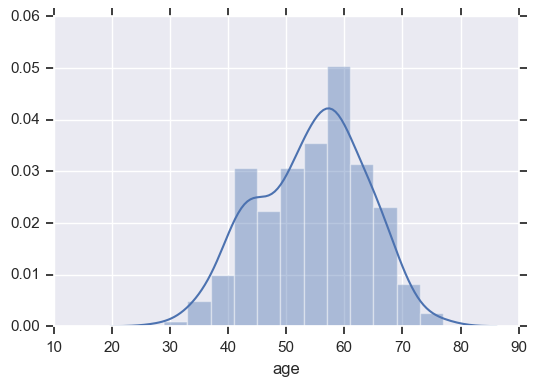

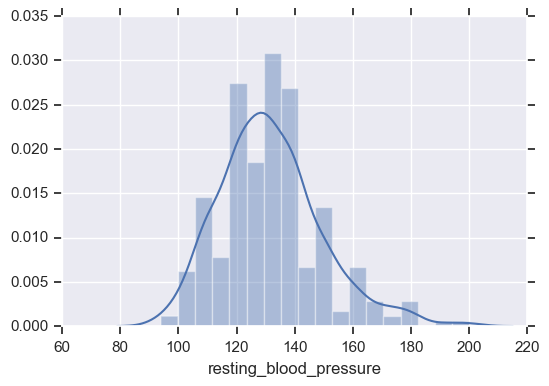

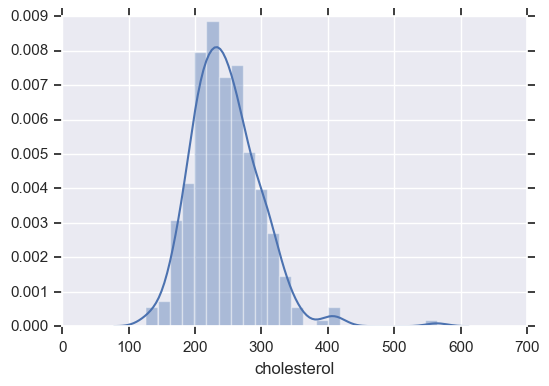

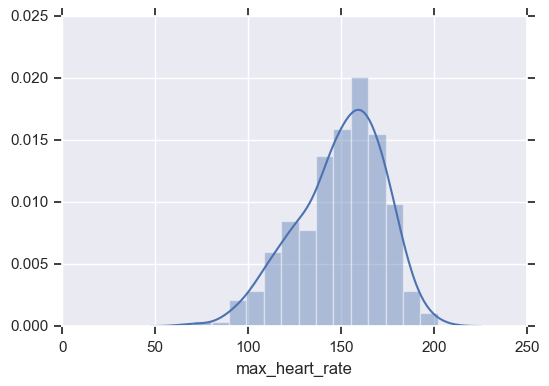

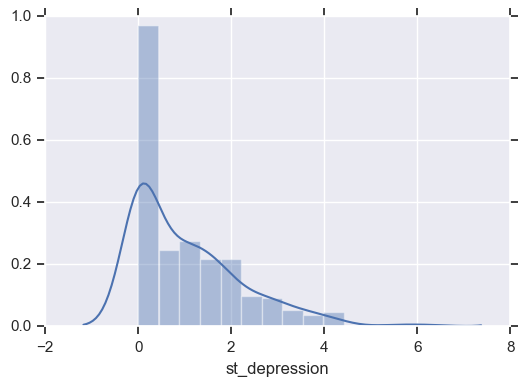

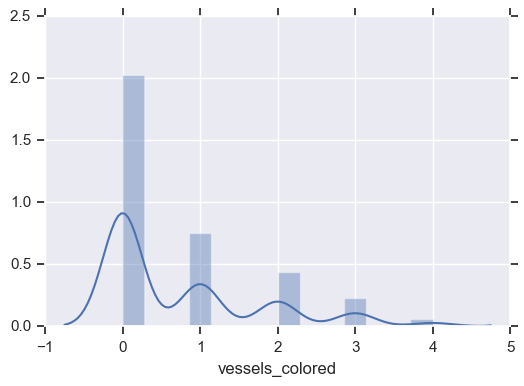

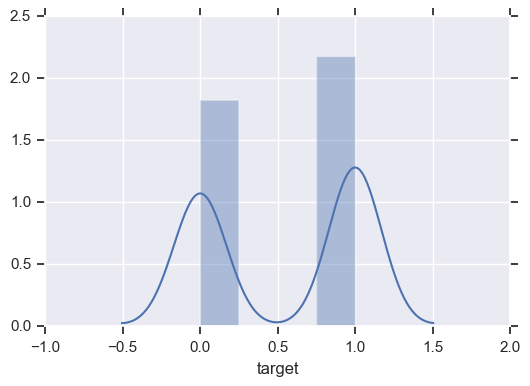

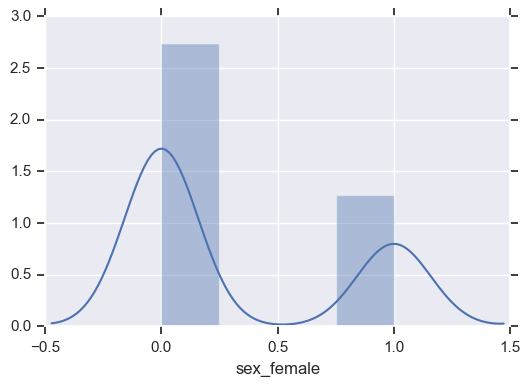

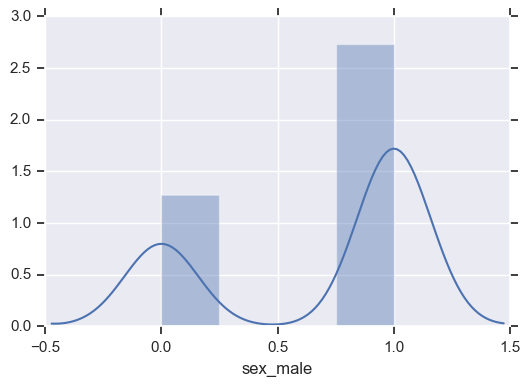

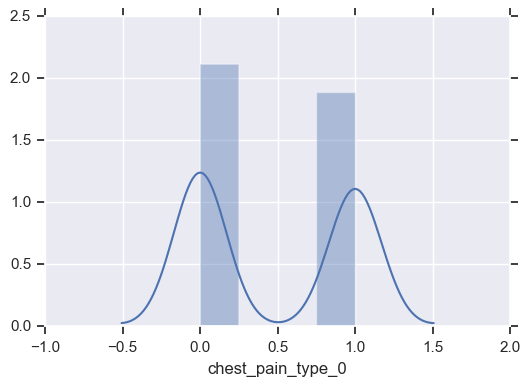

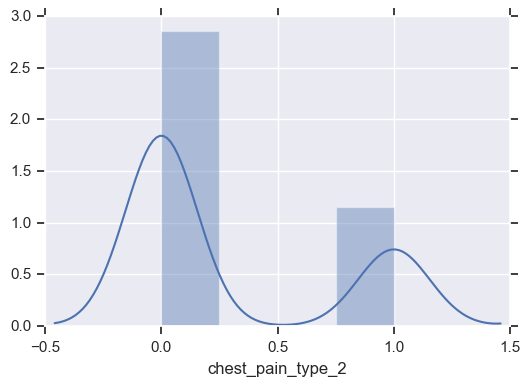

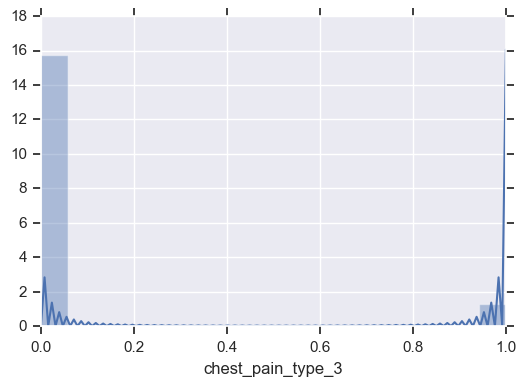

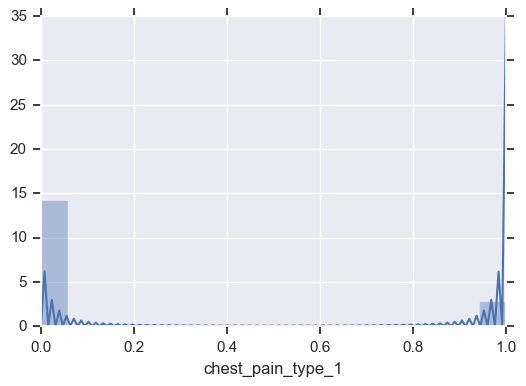

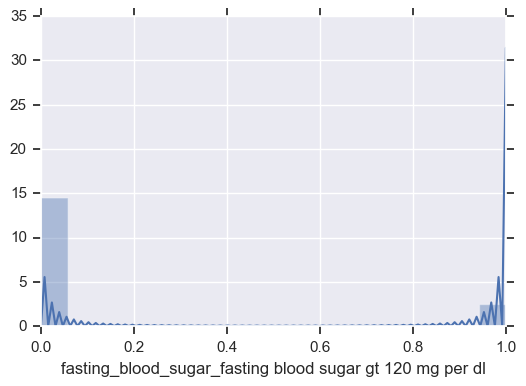

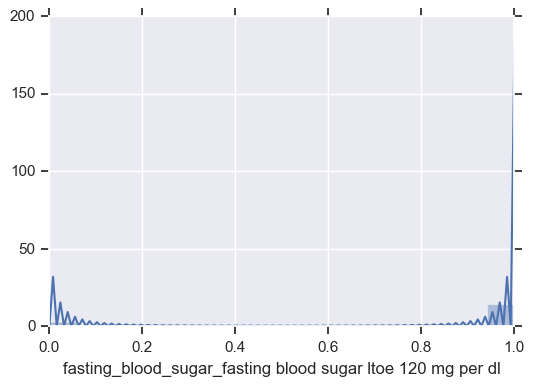

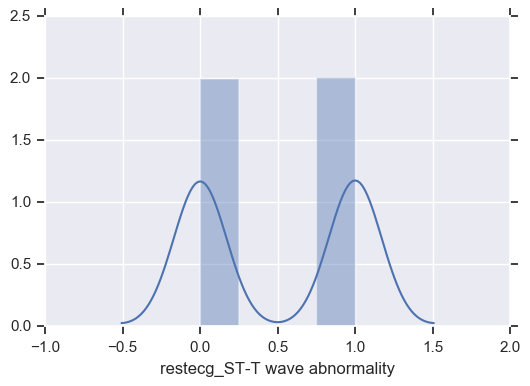

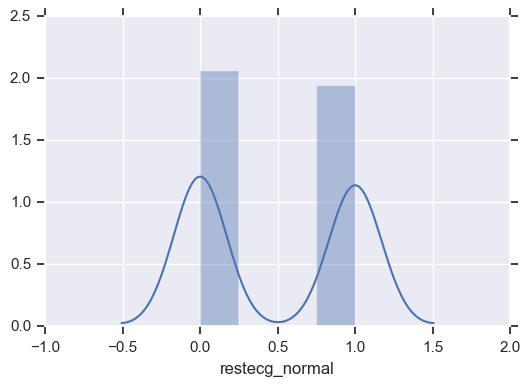

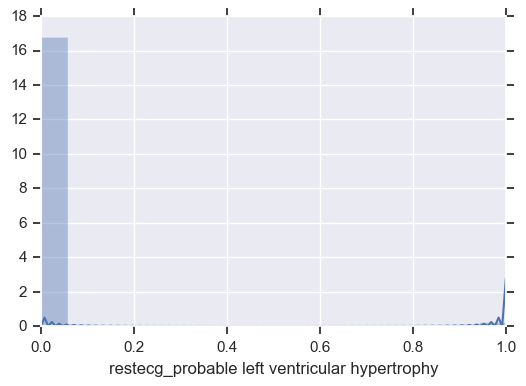

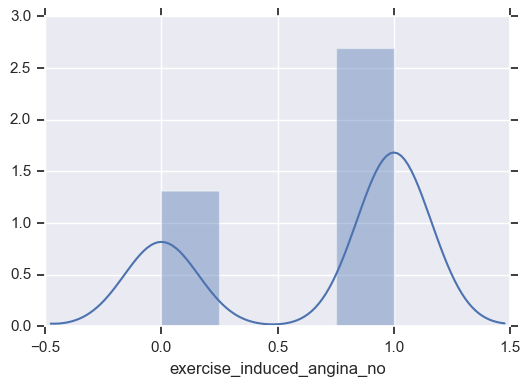

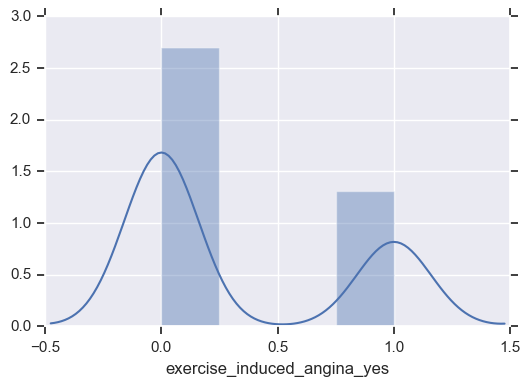

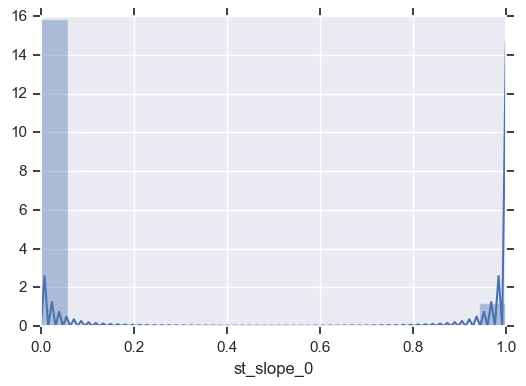

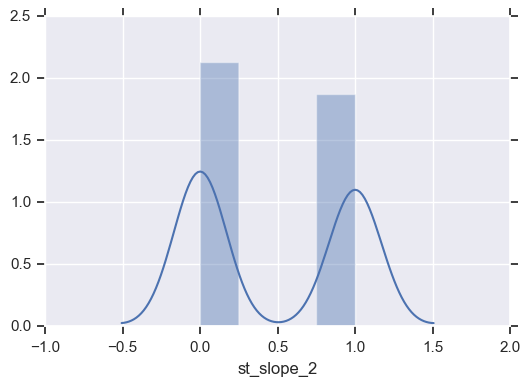

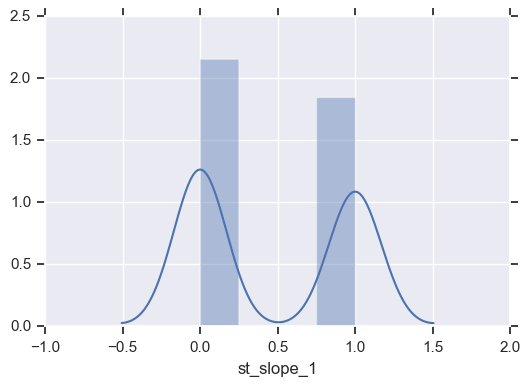

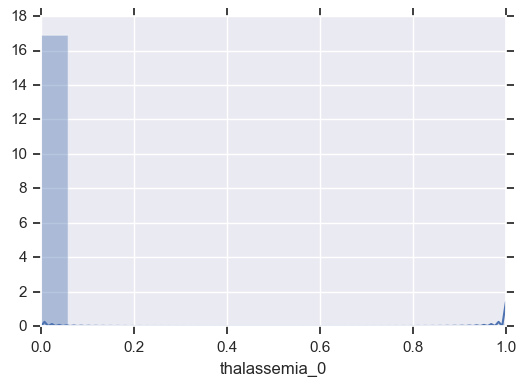

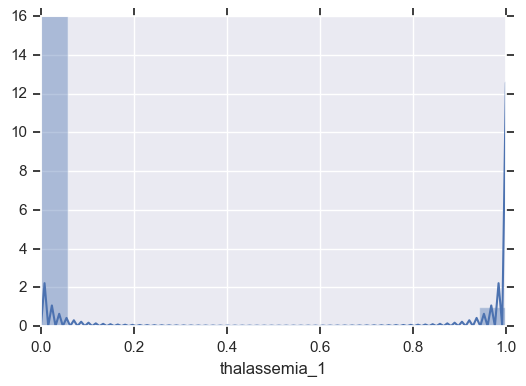

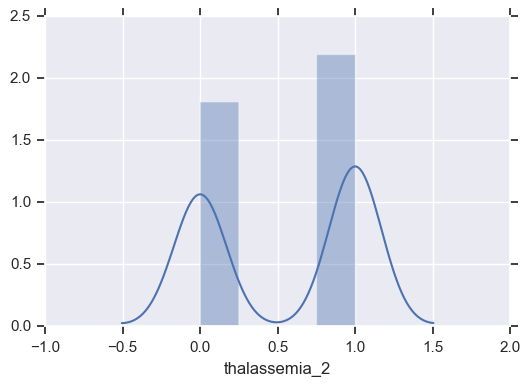

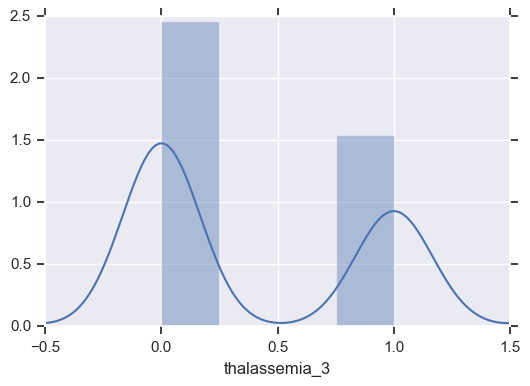

In [11]:
pd.set_option('display.max_rows', 50)
for column in hd.columns:
    sns.distplot(hd[column])
    plt.show()
    
# notice the imbalance in observations by sex

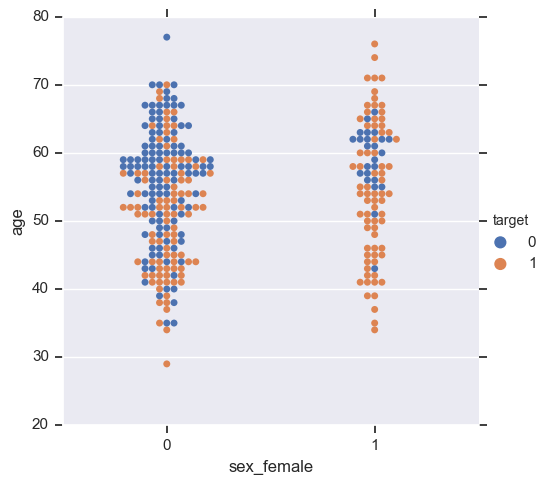

In [12]:
# explore demographic distribution
sns.catplot(x="sex_female", y="age", hue="target",
            kind="swarm", data=hd);
plt.show()

# women in the study appear to have a higher percentage of observations positive for heart disease
# both men and women in the study appear to have a higher probability of heart disease at a younger age

In [13]:
#dig further into the relationship between sex and heart disease
pd.crosstab(hd.sex_female, hd.target).apply(lambda r: r/r.sum(), axis=1)

# 75% of women in our dataset have heart disease
# only 45% of men have heart disease

target,0,1
sex_female,,
0,0.550725,0.449275
1,0.250000,0.750000


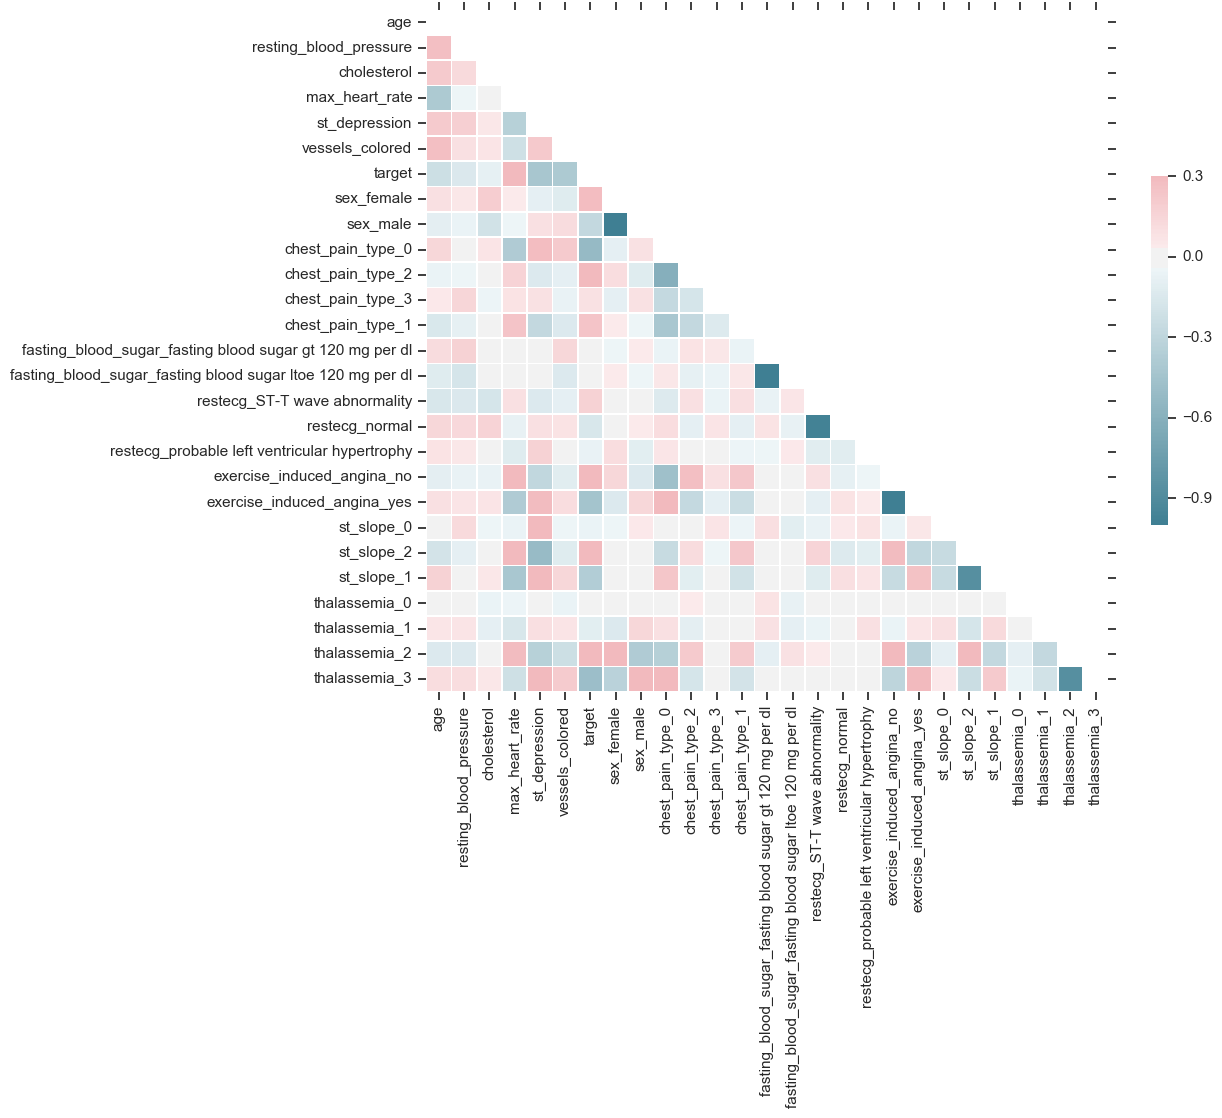

In [14]:
sns.set(style="white")

# Compute the correlation matrix
corr = hd.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

# some moderate correlation present between:
# slope and oldpeak
# thalach and age
# exang and cp
# trestbps and age
# thalach and age
# oldpeak and exang
# slope and thalach

In [15]:
x = hd.drop('target',axis=1)
x.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate,st_depression,vessels_colored,sex_female,sex_male,chest_pain_type_0,chest_pain_type_2,chest_pain_type_3,chest_pain_type_1,fasting_blood_sugar_fasting blood sugar gt 120 mg per dl,fasting_blood_sugar_fasting blood sugar ltoe 120 mg per dl,restecg_ST-T wave abnormality,restecg_normal,restecg_probable left ventricular hypertrophy,exercise_induced_angina_no,exercise_induced_angina_yes,st_slope_0,st_slope_2,st_slope_1,thalassemia_0,thalassemia_1,thalassemia_2,thalassemia_3
0,63,145,233,150,2.3,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0
1,37,130,250,187,3.5,0,0,1,0,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,1,0
2,41,130,204,172,1.4,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0
3,56,120,236,178,0.8,0,0,1,0,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,1,0
4,57,120,354,163,0.6,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0


In [16]:
y = hd['target']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [17]:
# apply dimensionality reduction to reduce features to 2 dimensions for plotting

# linear
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x)
x_pca = pca.transform(x)
x_pca.shape

(303, 2)

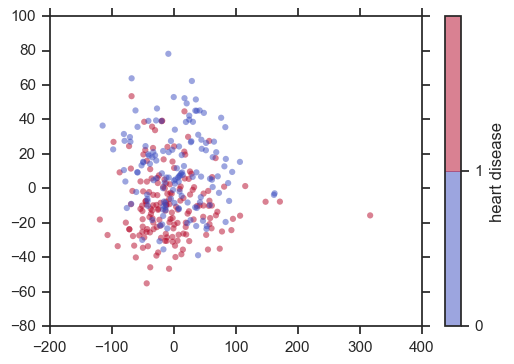

In [18]:
plt.scatter(x_pca[:,0], x_pca[:, 1], c=y, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('coolwarm',2))
plt.colorbar(label = 'heart disease',ticks=range(2))
plt.clim(0,2);
plt.show()

In [19]:
# nonlinear 
from sklearn.manifold import Isomap
iso=Isomap(n_components=2)
iso.fit(x)
data_projected = iso.transform(x)
data_projected.shape

(303, 2)

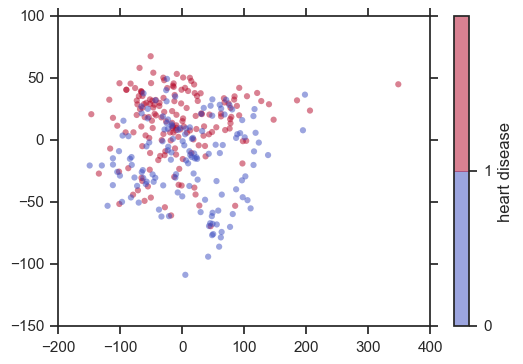

In [20]:
plt.scatter(data_projected[:,0], data_projected[:, 1], c=y, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('coolwarm',2))
plt.colorbar(label = 'heart disease',ticks=range(2))
plt.clim(0,2);
plt.show()

# Overall, the groups have some separation on the edges, but are not well separated in the center. 
# This will be a fun and challenging classification exercise

In [23]:
#from sklearn.cross_validation import train_test_split
#xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0)

from sklearn.cross_validation import ShuffleSplit
cv = ShuffleSplit(x.shape[0], n_iter=10, test_size=0.2, random_state=0)

In [24]:
def model_output():
    i = 0
    for train, test in cv:
        classifier.fit(xtrain, ytrain)
        probas_ = classifier.fit(xtrain, ytrain).predict_proba(xtest)
        y_model = classifier.predict(xtest)
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(ytest, probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
    
    #plot ROC
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right", fontsize="x-small")
    plt.show()
    
    #confusion matrix
    mat = confusion_matrix(ytest, y_model)
    sns.heatmap(mat, square=True, annot=True, cbar=False)
    plt.xlabel('predicted value')
    plt.ylabel('true value')
    plt.show()
    
    #output additional metrics
    best_parameters = classifier.best_estimator_.get_params()
    print("best params")
    for param_name in sorted(parameters.keys()):
        print(param_name, best_parameters[param_name])
    print("classification report")
    print(metrics.classification_report(ytest, y_model))

In [4]:
#from sklearn.model_selection import RepeatedKFold
#cv = ShuffleSplit(x.shape[0], n_iter=10, test_size=0.2, random_state=0)
#cv = RepeatedKFold(n_splits=10, n_repeats=2, random_state=random_state)
import sklearn
print(sklearn.__version__)

0.18.1


In [30]:
from sklearn.model_selection import RepeatedKFold

rkf = RepeatedKFold(n_splits=10, n_repeats=2, random_state=random_state)
>>> for train, test in rkf.split(X):
...     print("%s %s" % (train, test))

def model_output():
    i = 0
    for train, test in cv:
        classifier.fit(x[train], y[train])
        probas_ = classifier.fit(x[train], y[train]).predict_proba(x[test])
        y_model = classifier.predict(x[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(ytest, probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
    
    #plot ROC
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right", fontsize="x-small")
    plt.show()
    
    #confusion matrix
    mat = confusion_matrix(ytest, y_model)
    sns.heatmap(mat, square=True, annot=True, cbar=False)
    plt.xlabel('predicted value')
    plt.ylabel('true value')
    plt.show()
    
    #output additional metrics
    best_parameters = classifier.best_estimator_.get_params()
    print("best params")
    for param_name in sorted(parameters.keys()):
        print(param_name, best_parameters[param_name])
    print("classification report")
    print(metrics.classification_report(ytest, y_model))

In [31]:
# start with Gaussian Naive Bayes

from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()

model_output()

KeyError: '[ 74 153  64 296 287 286 236 126  73  20  46 160 232 181  27 173 261  37\n 101 166 233 184 164 206 248 253 293  76 272 238 137 106 284  44 139 247\n 288 156 297 252  54 234  18 205 254 182  56  71 144 249 209 290 219 158\n 176  33  83 136 210 118  60 159 282 110  21  29 150  16  75 109 179 283\n   4  96 229  61  67 295 266 171 281  40 189  13 107 200   3 161 125  24\n  30  77 279 190  19 257 235 268  80  51   2 239 104 262  86  10 224  58\n  41  14 155  50 215 237 123 220  62 191 230 130 213 187  43 114 138 199\n 222 149 112 298  98 221  93 208 162  36 178 113   0  94 294  95 299 263\n 256  69  49  48  85 300 141 207  23 250 148 143  78 180 100 204 131 269\n 301 196   6  68 203  84 170 121 140 258 276 142 259  91  82 285  11 119\n 102  35  57 169 231  65   1 120 267 186  42 105 132  79  17 271  38  53\n 260 128  28 183 163 151 244 202  31  32 127 185 280 273 147 278 177  99\n 197 243 115 265  72  25 165 289 174 291  39 193  88  70  87 292 242 277\n 211   9 195 251 192 117  47 172] not in index'

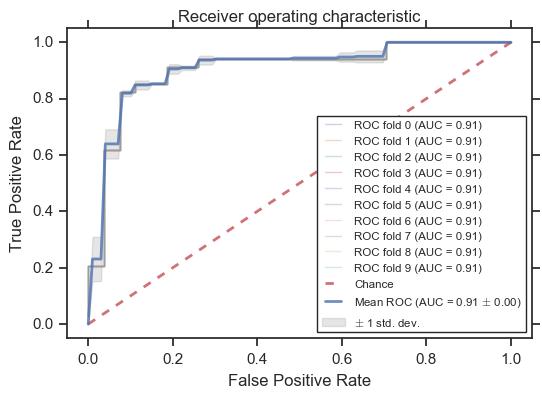

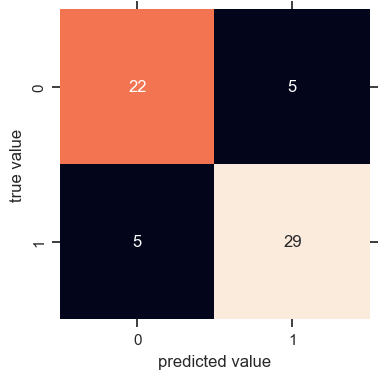

best params
C 0.5
classification report
             precision    recall  f1-score   support

          0       0.81      0.81      0.81        27
          1       0.85      0.85      0.85        34

avg / total       0.84      0.84      0.84        61



In [75]:
#TEST SCALING

# try logistic regression

from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(random_state=0, multi_class='ovr', solver='liblinear', penalty='l1')
parameters = {
        'C': (0.01,0.1,0.5,0.9,0.99),
#        'multiclass': ('ovr','multinomial')
}
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)

model_output()

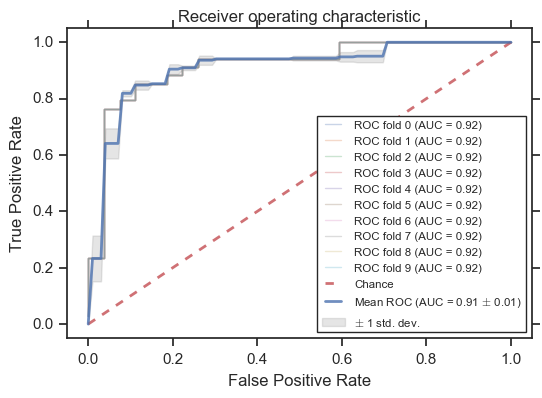

best params
C 0.1
multi_class ovr
solver newton-cg
classification report
             precision    recall  f1-score   support

          0       0.85      0.81      0.83        27
          1       0.86      0.88      0.87        34

avg / total       0.85      0.85      0.85        61



In [73]:
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(random_state=0, penalty='l2')
parameters = {
        'multi_class': ('ovr','multinomial'),
        'solver': ('newton-cg','lbfgs'),
        'C': (0.01,0.1,0.5,0.9,0.99),
}
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)

model_output()

In [ ]:
#TEST SCALING
#Long Run Time

# support vector machines

from sklearn.svm import SVC

estimator = SVC(random_state=0, kernel='linear', probability=True)
parameters = {
        'C': (0.01,0.05,0.1,0.5,0.9,0.99),
}
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)

model_output()

In [29]:
estimator = SVC(random_state=0)
parameters = {
        'C': (0.01,0.05,0.1,0.5,0.9,0.99),
        'kernel': ('rbf', 'sigmoid'),
        'gamma': (0.001,0.01,0.05,0.1,0.5,0.9),
}
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)

model_output()

#classifier.fit(xtrain, ytrain)
#classifier.best_score_

#best_parameters = classifier.best_estimator_.get_params()
#for param_name in sorted(parameters.keys()):
#    print(param_name, best_parameters[param_name])

#y_model = classifier.predict(xtest)
#print(metrics.classification_report(ytest, y_model))

C 0.99
gamma 0.001
kernel rbf
             precision    recall  f1-score   support

          0       0.59      0.70      0.64        27
          1       0.72      0.62      0.67        34

avg / total       0.67      0.66      0.66        61



In [ ]:
#DOES NOT COMPLETE

estimator = SVC(random_state=0, kernel='poly')
parameters = {
        'C': (0.1,0.5,0.9),
        'degree': (2,3,4),
        'gamma': (0.1,0.5,0.9),
}
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)

model_output()

#classifier.fit(xtrain, ytrain)
#classifier.best_score_

#best_parameters = classifier.best_estimator_.get_params()
#for param_name in sorted(parameters.keys()):
#    print(param_name, best_parameters[param_name])

#y_model = classifier.predict(xtest)
#print(metrics.classification_report(ytest, y_model))

In [41]:
# random forest

from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(random_state=0)
parameters = {
        'n_estimators': (10,50,100),
        'max_depth': (2,4,6,10),
        'min_samples_leaf': (2,3,5),
        'min_samples_split': (2,6,10),
}
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)

model_output()

#classifier.fit(xtrain, ytrain)
#classifier.best_score_

#best_parameters = classifier.best_estimator_.get_params()
#for param_name in sorted(parameters.keys()):
#    print(param_name, best_parameters[param_name])

#y_model = classifier.predict(xtest)
#print(metrics.classification_report(ytest, y_model))

##model = RandomForestClassifier(n_estimators=1000, random_state=0)
##model.fit(xtrain,ytrain)
#ypred = model.predict(xtest)
##from sklearn import metrics
##y_model = model.predict(xtest)
##print(accuracy_score(ytest, y_model))
##print(metrics.classification_report(classifier.predict, ytest))
#mat = confusion_matrix(ytest, ypred)
#sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
#plt.xlabel('predicted value')
#plt.ylabel('true value')
#plt.show()

max_depth 4
min_samples_leaf 5
min_samples_split 2
n_estimators 50
             precision    recall  f1-score   support

          0       0.85      0.85      0.85        27
          1       0.88      0.88      0.88        34

avg / total       0.87      0.87      0.87        61



In [ ]:
#LONG RUN TIME AND NO RESULTS

#linear discriminant analysis

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

estimator = LinearDiscriminantAnalysis()
parameters = {
           'store_covariance': (0,0.01,0.1,0.5,0.9,1),
           'tol': (0.01,0.1,0.5,0.9,0.99),
           'n_components': (1,2,3,4,5)
}
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)

model_output()

#classifier.fit(xtrain, ytrain)
#classifier.best_score_

#best_parameters = classifier.best_estimator_.get_params()
#for param_name in sorted(parameters.keys()):
#    print(param_name, best_parameters[param_name])

#y_model = classifier.predict(xtest)
#print(metrics.classification_report(ytest, y_model))

C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Eric\Anaconda3\lib\

In [34]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

estimator = LinearDiscriminantAnalysis()
parameters = {
           'solver': ('lsqr','eigen'),
           'shrinkage': (0,0.01,0.1,0.5,0.9,1),
           'n_components': (1,2,3,4,5)
}
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)

model_output()

#classifier.fit(xtrain, ytrain)
#classifier.best_score_

#best_parameters = classifier.best_estimator_.get_params()
#for param_name in sorted(parameters.keys()):
#    print(param_name, best_parameters[param_name])

#y_model = classifier.predict(xtest)
#print(metrics.classification_report(ytest, y_model))

#model = LinearDiscriminantAnalysis(n_components=1)
#model.fit(xtrain, ytrain)
#y_model = model.predict(xtest)
#accuracy_score(ytest, y_model)

LinAlgError: the leading minor of order 14 of 'b' is not positive definite. The factorization of 'b' could not be completed and no eigenvalues or eigenvectors were computed.

In [35]:
#gradient boosted machine

from sklearn.ensemble import GradientBoostingClassifier
estimator = GradientBoostingClassifier(random_state=0)
parameters = {
           'n_estimators': (5,10,25,75,100),
           'learning_rate': (0.01,0.1,0.5,0.9,0.95),
           'max_features': (1,2,3,4,5),
           'max_depth': (1,2,3,4,5)
}
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)

model_output()

#classifier.fit(xtrain, ytrain)
#classifier.best_score_

#best_parameters = classifier.best_estimator_.get_params()
#for param_name in sorted(parameters.keys()):
#    print(param_name, best_parameters[param_name])

#y_model = classifier.predict(xtest)
#print(metrics.classification_report(ytest, y_model))

#learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
#scores = {}
#scores_list = []
#for l in learning_rates:
#    model = GradientBoostingClassifier(n_estimators=20, learning_rate = l, max_features=2, max_depth = 2, random_state = 0)
#    model.fit(xtrain, ytrain)
    ##print("Learning rate: ", learning_rate)
    ##print("Accuracy score (training): {0:.3f}".format(gb.score(X_train_sub, y_train_sub)))
    ##print("Accuracy score (validation): {0:.3f}".format(gb.score(X_validation_sub, y_validation_sub)))
    ##print()
#    y_model = model.predict(xtest)
#    scores[l] = accuracy_score(ytest, y_model)
#    scores_list.append(accuracy_score(ytest, y_model))
#print(scores_list)

learning_rate 0.95
max_depth 1
max_features 5
n_estimators 5
             precision    recall  f1-score   support

          0       0.79      0.81      0.80        27
          1       0.85      0.82      0.84        34

avg / total       0.82      0.82      0.82        61



In [36]:
#TEST SCALING

#knn

from sklearn.neighbors import KNeighborsClassifier

estimator = KNeighborsClassifier()
parameters = {
           'n_neighbors': (2,6,10,15,20,25),
           'leaf_size': (1,2,3,4,5)
}
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)

model_output()

#classifier.fit(xtrain, ytrain)
#classifier.best_score_

#best_parameters = classifier.best_estimator_.get_params()
#for param_name in sorted(parameters.keys()):
#    print(param_name, best_parameters[param_name])

#y_model = classifier.predict(xtest)
#print(metrics.classification_report(ytest, y_model))

#k_range = range(1,26)
#scores = {}
#scores_list = []
#for k in k_range:
#    model = KNeighborsClassifier(n_neighbors=k)
#    model.fit(xtrain,ytrain)
#    y_model = model.predict(xtest)
#    scores[k] = accuracy_score(ytest, y_model)
#    scores_list.append(accuracy_score(ytest, y_model))
#print(scores_list)

leaf_size 1
n_neighbors 20
             precision    recall  f1-score   support

          0       0.62      0.78      0.69        27
          1       0.78      0.62      0.69        34

avg / total       0.71      0.69      0.69        61



In [39]:
#Stochastic gradient descent

from sklearn.linear_model import SGDClassifier

estimator = SGDClassifier(random_state=0, penalty='elasticnet')
parameters = {
           'loss': ('hinge','modified_huber','squared_hinge','perceptron'),
           'alpha': (0.0001,0.001,0.1,0.5,0.9),
           'l1_ratio': (0,0.1,0.5,0.9,1),
}
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=parameters)

model_output()

#classifier.fit(xtrain, ytrain)
#classifier.best_score_

#best_parameters = classifier.best_estimator_.get_params()
#for param_name in sorted(parameters.keys()):
#    print(param_name, best_parameters[param_name])

#y_model = classifier.predict(xtest)
#print(metrics.classification_report(ytest, y_model))

alpha 0.5
l1_ratio 0.9
loss modified_huber
             precision    recall  f1-score   support

          0       0.71      0.56      0.63        27
          1       0.70      0.82      0.76        34

avg / total       0.71      0.70      0.70        61



In [ ]:
#how should we adjust classification threshold?
